In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 6))

In [3]:
house_data = pd.read_csv("house_data.csv")
house_data.head()

,price,surface,arrondissement
0,1820,46.1,1.0
1,1750,41.0,1.0
2,1900,55.0,1.0
3,1950,46.0,1.0
4,1950,49.0,1.0


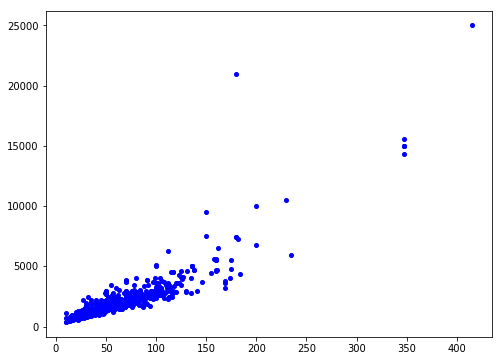

In [4]:
plt.plot(house_data['surface'], house_data['price'], 'bo', markersize=4)
plt.show()

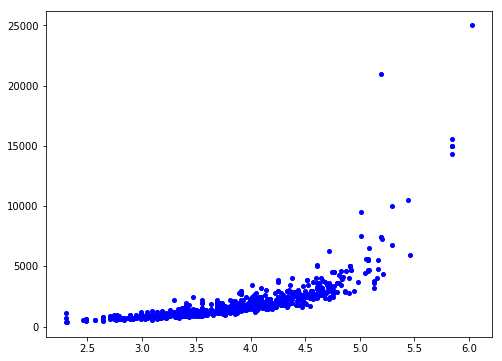

In [5]:
plt.plot(np.log(house_data['surface']), house_data['price'], 'bo', markersize=4)
plt.show()

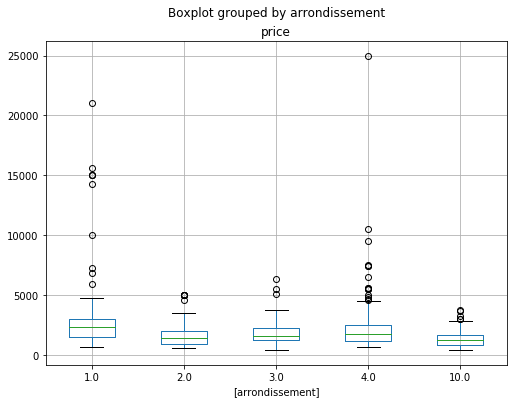

In [6]:
house_data[["price", "arrondissement"]].boxplot(by="arrondissement")

In [7]:
print(house_data[house_data["arrondissement"].isna()])
house_data.dropna(inplace=True)

     price  surface  arrondissement
149   3000      NaN             NaN
339    980      NaN             NaN
509   1590      NaN             NaN
674   1580      NaN             NaN
742    450      NaN             NaN


In [8]:
t = preprocessing.OneHotEncoder().fit_transform(house_data[["arrondissement"]]).toarray()
house_data = pd.concat([house_data[["price", "surface", "arrondissement"]], pd.DataFrame(t, index=house_data.index)], axis=1)
house_data.head()

,price,surface,arrondissement,0,1,2,3,4
0,1820,46.1,1.0,1.0,0.0,0.0,0.0,0.0
1,1750,41.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1900,55.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1950,46.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1950,49.0,1.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# Using cross validation to obtain robust scores to compare different models.
# ShuffleSplit will ensure that each cross validation split will have samples from all arrondissements
cv = ShuffleSplit(n_splits=10, random_state=53)
models = {}
scores = {}

In [11]:
# Baseline: linear model with only 1 feature: 'surface'
X = house_data[['surface']]
y = house_data['price']

linear_surface = linear_model.LinearRegression()
linear_surface_results = cross_validate(linear_surface, X, y, scoring=None, cv=cv, return_train_score=False)
linear_surface_test_score = linear_surface_results['test_score'].mean()
print(linear_surface_test_score)
scores["Linear - surface only"] = linear_surface_test_score

0.7926847009639096


In [16]:
models["Linear - all"] = linear_model.LinearRegression()
# Huber regressor is more robust to outliers
models["Huber"] = linear_model.HuberRegressor()
# Polynomial features may fit better the distribution
models["Linear with Polynomial features"] = make_pipeline(preprocessing.MaxAbsScaler(),
                                                          PolynomialFeatures(degree=2, interaction_only=False),
                                                          linear_model.LinearRegression())

In [17]:
X = house_data[['surface', 0, 1, 2, 3, 4]].copy()
y = house_data['price']

for name, model in models.items():
    results = cross_validate(model, X, y, scoring=None, cv=cv, return_train_score=False)
    average_test_score = results['test_score'].mean()
    scores[name] = average_test_score

In [18]:
scores_df = pd.DataFrame(list(scores.values()), list(scores.keys()), ["Score"])
scores_df

,Score
Linear - surface only,0.792685
Linear - all,0.803634
Huber,0.814829
Linear with Polynomial features,0.885163


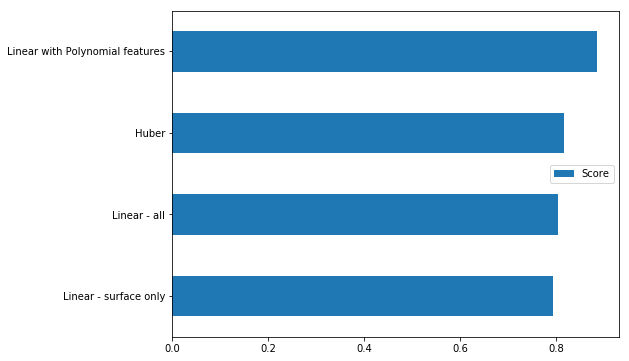

In [19]:
scores_df.plot(kind='barh')